In [1]:
import torch
from torchdiffeq import odeint
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set(style="darkgrid", palette="muted", font="serif")
plt.rcParams.update(plt.rcParamsDefault)

from abc import ABC, abstractmethod
import time
from typing import Callable, Tuple, List, Optional
import random
import itertools
from scipy.integrate import solve_ivp

from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.fit_motif import *
from scripts.time_series import *

plt.rcParams['xtick.labelsize'] = 14  # font size
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams["font.family"] = "serif"
mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts (editable in Illustrator)
mpl.rcParams['ps.fonttype'] = 42   # Same for EPS
mpl.rcParams['svg.fonttype'] = 'none'  # Keep text as text in SVG

set_seed(313)

In [3]:
# generate trajectories for the target system
dt = 0.005
num_points = 100
dim = 3  # Three species
ml_system = MayLeonardSystem(dim=dim) 
lorenz_system = LorenzSystem(dim=dim, sigma=10, rho=313, beta=8/3.)   #gaiko2014global
lorenz_system = LorenzSystem(dim=dim, sigma=10, rho=350, beta=8/3.)   #gaiko2014global

noise_level = 0.
time_span = torch.tensor([0.0, 5])
init_points_bounds = [(44.7, 44.8), (80.7, 80.8), (352.3, 352.4)]  # 3D bounds
init_points_bounds = [(44, 45), (80, 81), (352, 353)]  # 3D bounds
#init_points_bounds = [(40, 50), (80, 90), (300, 400)]  # 3D bounds
init_points_bounds = [(0, 100), (0, 100), (0, 100)]  # 3D bounds


t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method='uniform',         # Specifies the density-based sampling method
    init_points_bounds=init_points_bounds,                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=dt, num_points=num_points,                     # Number of initial points to sample
    system=lorenz_system           # The target system, e.g., VanDerPol system
)

#time_span = torch.tensor([0.0, .2])
# initial_conditions = [trajectories_target[_, 8*_,:].clone().detach().numpy() for _ in range(num_points)] # Use the last point of the trajectory as the initial condition for the next trajectory
# t_values, trajectories_target, initial_conditions_target = generate_trajectories(
#     predefined_initial_conditions       =initial_conditions, # Predefined initial conditions for the target system
#     time_span=time_span, # Time span for trajectory generation
#     dt=dt, num_points=num_points,                     # Number of initial points to sample
#     system=lorenz_system           # The target system, e.g., VanDerPol system
# )

trajectories_target, _, mean, std= normalize_scale_pair(trajectories_target, False)


torch.Size([100, 100, 3])


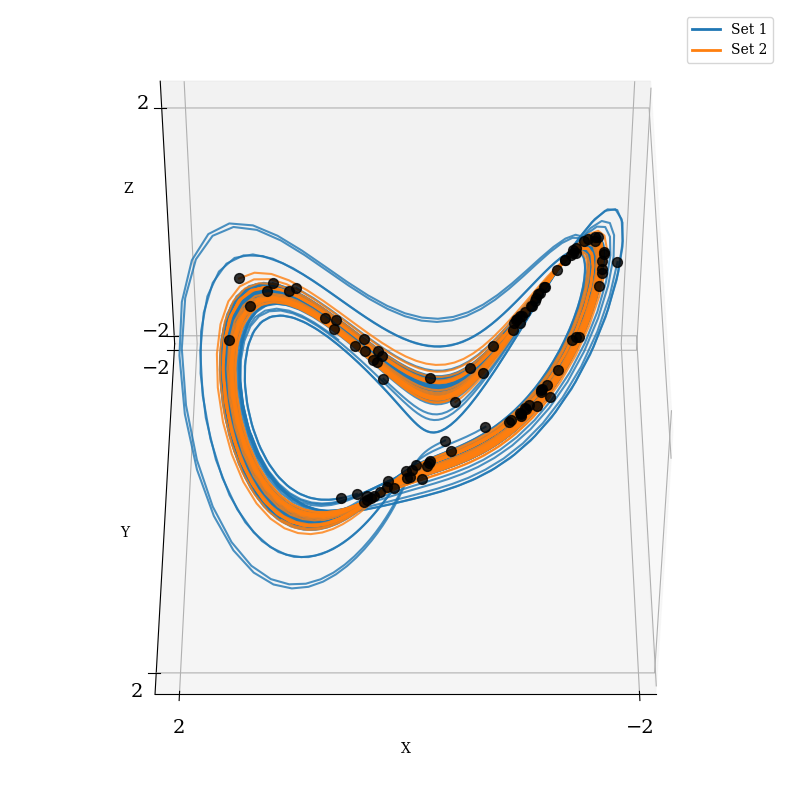

In [4]:
trajectories_target_s = trajectories_target[:,250:350,:]
print(trajectories_target_s.shape)
train_ratio = 0.8
B = trajectories_target_s.shape[0]
n_train = int(train_ratio * B)
n_test = B - n_train
train_set, test_set = random_split(trajectories_target_s, [n_train, n_test])
trajectories_target_train = trajectories_target_s[train_set.indices]
trajectories_target_test = trajectories_target_s[test_set.indices]
plot_trajectories_3d([trajectories_target_train, trajectories_target_test], elev=45, azim=90)


In [ ]:
time_span = torch.tensor([0.0, 100*dt])
source_system = AnalyticalLimitCycle(dim=3, dt=dt, time_span=time_span, velocity_init=-1., alpha_init=-1)

num_epochs = 1000
layer_sizes= 1*[128]
lr = .01
annealing_params = {'initial_std': .0, 'final_std': 0., 'dynamic': False}
training_params = {'num_epochs': num_epochs, 'batch_size': 32, 'lr': lr, 'annealing_params': annealing_params}
homeo = NODEHomeomorphism(dim=dim, layer_sizes=layer_sizes)
homeo_ds_net = Homeo_DS_Net(homeo, source_system)
homeo_ds_net, losses, grad_norms = train_homeo_ds_net_batched(homeo_ds_net=homeo_ds_net, trajectories_target=trajectories_target_s, **training_params)

Epoch 0, log(Loss)= 0.0148 Velocity:  -1.006
Epoch 10, log(Loss)= -0.1211 Velocity:  -0.888
Epoch 20, log(Loss)= -0.1285 Velocity:  -0.733
Epoch 30, log(Loss)= -0.1260 Velocity:  -0.476
Epoch 40, log(Loss)= -0.1307 Velocity:  -0.144
Epoch 50, log(Loss)= -0.1314 Velocity:  0.171
Epoch 60, log(Loss)= -0.1366 Velocity:  0.496
Epoch 70, log(Loss)= -0.1294 Velocity:  0.841
Epoch 80, log(Loss)= -0.1390 Velocity:  1.133


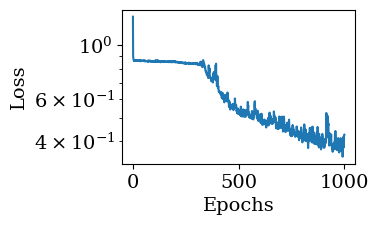

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(losses)
ax.set_yscale('log')
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
plt.show()

In [ ]:
trajectories_source, transformed_trajectories, error = test_single_homeo_ds_net(homeo_ds_net, trajectories_target_s) #, time_span=np.array([0.0, 1.0]))
#trajectories_centered = ((transformed_trajectories + 1) / 2) * (max_vals.detach().numpy() - min_vals.detach().numpy()) + min_vals.detach().numpy()
#transformed_trajectories_list[0] = trajectories_centered

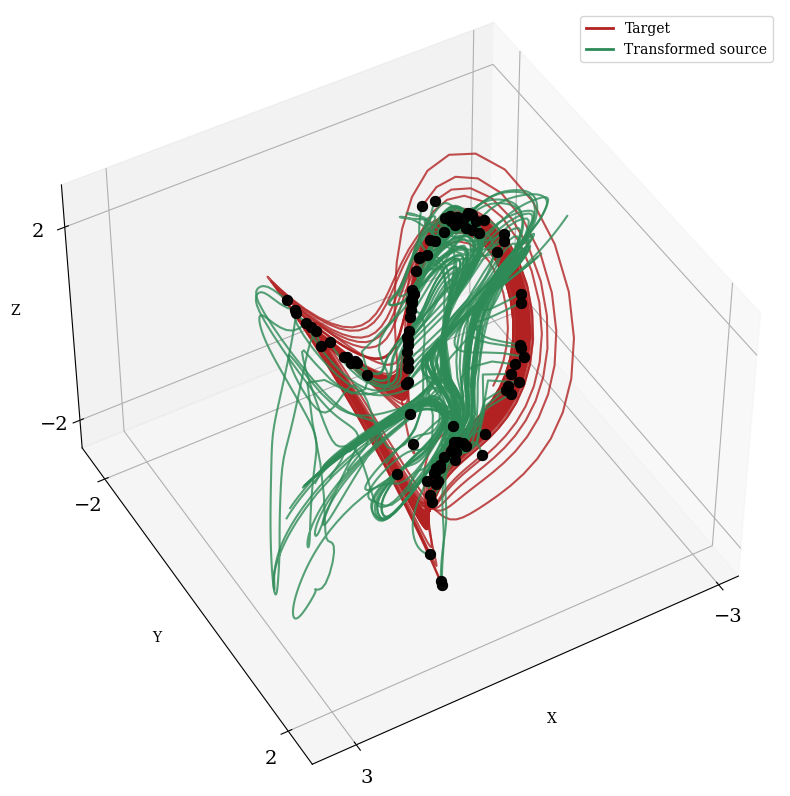

In [ ]:
plot_trajectories_3d([trajectories_target_s, transformed_trajectories],
                     labels=['Target', 'Transformed source'],
                     colors=['firebrick', 'seagreen'],
                     #save_name='lorenz_node_analytical.pdf',
                       elev=45, azim=60)

In [26]:
#save_homeo_ds_net(homeo_ds_networks[0], "model_lorenz_analytical.pth")

In [ ]:
jacobian_norm_over_batch(homeo, trajectories_target.reshape(-1,dim), norm_type='fro', normalize=True)  

tensor(3.5870)